In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.constraints import Constraint
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt



import numpy as np
import time
from tqdm import tqdm

epsilon = 20 # control the sparsity level as discussed in the paper
zeta = 0.3 # the fraction of the weights removed
batch_size = 150 # batch size
maxepoches = 100 # number of epochs
learning_rate = 0.01 # SGD learning rate
num_classes = 10 # number of classes
momentum=0.9 # SGD momentum

In [2]:
def read_data():
    #read CIFAR10 data
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    #normalize data
    xTrainMean = np.mean(x_train, axis=0)
    xTtrainStd = np.std(x_train, axis=0)
    x_train = (x_train - xTrainMean) / xTtrainStd
    x_test = (x_test - xTrainMean) / xTtrainStd

    return [x_train, x_test, y_train, y_test]

In [3]:
class MaskWeights(Constraint):
    def __init__(self, mask_var: tf.Variable):
        super().__init__()
        self.mask_var = mask_var  # tf.Variable, updated in-place

    def __call__(self, w):
        return w * tf.cast(self.mask_var, w.dtype)

    def get_config(self):
        return {}

In [4]:
class SReLU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        param_shape = (1,) * (len(input_shape) - 1) + (input_shape[-1],)

        self.t_l = self.add_weight(
            name="t_l", shape=param_shape,
            initializer=tf.keras.initializers.Zeros(),
            trainable=True
        )
        self.a_l = self.add_weight(
            name="a_l", shape=param_shape,
            initializer=tf.keras.initializers.Constant(0.2),
            trainable=True
        )
        self.t_r = self.add_weight(
            name="t_r", shape=param_shape,
            initializer=tf.keras.initializers.Constant(1.0),
            trainable=True
        )
        self.a_r = self.add_weight(
            name="a_r", shape=param_shape,
            initializer=tf.keras.initializers.Constant(0.2),
            trainable=True
        )

    def call(self, x):
        left = self.t_l + self.a_l * (x - self.t_l)
        right = self.t_r + self.a_r * (x - self.t_r)
        return tf.where(
            x <= self.t_l,
            left,
            tf.where(x >= self.t_r, right, x)
        )

In [5]:
def create_sparse_mask(shape, epsilon=20):  
    nin = shape[0]
    nout = shape[1]
    prob = (epsilon * (nin + nout)) / (nin * nout)
    print(prob)
    return np.random.rand(*shape) < prob

In [6]:
[x_train,x_test,y_train,y_test] = read_data()

In [7]:
mask1 = tf.Variable(
    create_sparse_mask((3072, 4000)),
    dtype=tf.float32,
    trainable=False,
    name="mask_sparse_1"
)
mask2 = tf.Variable(
    create_sparse_mask((4000, 1000)),
    dtype=tf.float32,
    trainable=False,
    name="mask_sparse_2"
)
mask3 = tf.Variable(
    create_sparse_mask((1000, 4000)),
    dtype=tf.float32,
    trainable=False,
    name="mask_sparse_3"
)

0.011510416666666667
0.025
0.025


In [8]:
# Basic MLP
model = models.Sequential()

# create a SET-MLP model for CIFAR10 with 3 hidden layers
model.add(Flatten(input_shape=(32, 32, 3)))

model.add(Dense(4000, name="sparse_1", kernel_constraint=MaskWeights(mask1)))
model.add(SReLU(name="srelu1"))
model.add(Dropout(0.3))

model.add(Dense(1000, name="sparse_2", kernel_constraint=MaskWeights(mask2)))        
model.add(SReLU(name="srelu2"))
model.add(Dropout(0.3))

model.add(Dense(4000, name="sparse_3", kernel_constraint=MaskWeights(mask3)))
model.add(SReLU(name="srelu3"))
model.add(Dropout(0.3))

model.add(Dense(num_classes, name="dense_4"))
model.add(Activation("softmax"))

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

D:\Conda\envs\ML\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sparse_1 (Dense)                     │ (None, 4000)                │      12,292,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ srelu1 (SReLU)                       │ (None, 4000)                │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sparse_2 (Dense)                     │ (None, 1000)                │       4,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ srelu2 (SReLU)                       │ (None, 1000)                │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sparse_3 (Dense)                     │ (None, 4000)                │       4,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ srelu3 (SReLU)                       │ (None, 4000)                │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          40,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,373,010 (77.72 MB)

 Trainable params: 20,373,010 (77.72 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def prune(Weight, Mask):
    W = Weight.numpy()
    M = Mask.numpy().astype(bool)

    flat_W = W.ravel()
    mask_flat = M.ravel()

    nz_indices = np.where(mask_flat)[0]
    nz_values = flat_W[nz_indices]

    if len(nz_indices) == 0:
        return 0

    sorted_idx = np.argsort(np.abs(nz_values))

    k = int(zeta * len(nz_indices))
    k = max(1, min(k, len(nz_indices)))

    prune_indices = nz_indices[sorted_idx[:k]]

    rows = prune_indices // W.shape[1]
    cols = prune_indices % W.shape[1]

    # prune
    W[rows, cols] = 0.0
    M[rows, cols] = False

    Weight.assign(W)
    Mask.assign(M.astype(Mask.dtype.as_numpy_dtype))

    return k
    

In [10]:
def regrow(Weight, Mask, k):
    W = Weight.numpy()
    M = Mask.numpy().astype(bool)

    mask_flat = M.ravel()

    # Find dead edges
    zero_idx = np.where(mask_flat == False)[0]

    k = min(k, len(zero_idx))
    if k == 0:
        return 0

    # Randomly select indices to regrow
    grow_idx = np.random.choice(zero_idx, size=k, replace=False)

    rows = grow_idx // W.shape[1]
    cols = grow_idx % W.shape[1]

    # Random initialization for new weights
    W[rows, cols] = np.random.normal(0, 0.1, size=k)
    M[rows, cols] = True

    Weight.assign(W)
    Mask.assign(M.astype(Mask.dtype.as_numpy_dtype))

    return k

In [11]:
def hidden_layer_neuron_importance(
    W_in,  M_in=None,     # (n_cur,  n_prev)
    W_out=None, M_out=None,  # (n_next, n_cur)
    eps=1e-12,
):
    W = W_in.numpy()
    A_in = np.abs(W)
    if M_in is not None:
        A_in *= M_in.numpy().astype(bool)

    incoming = A_in.sum(axis=0)  # sum over prev neurons

    if W_out is None:
        # If no outgoing matrix provided
        I = incoming.copy()
    else:
        A_out = np.abs(W_out.numpy())
        if M_out is not None:
            A_out *= M_out.numpy().astype(bool)

        outgoing = A_out.sum(axis=1)  # sum over next neurons
        I = incoming * outgoing

    I = np.clip(I.astype(np.float64), 0.0, None)
    I = np.log1p(I) # Taming the monsters :)
    I = I / (I.mean() + eps)

    return I

In [12]:
def regrow_importance(Weight, Mask, k, I_target, I_source, alpha=0.7, eps=1e-12):
    W = Weight.numpy()
    M = Mask.numpy().astype(bool)

    # dead edges
    zeros = np.argwhere(~M)              # (N_zero, 2) rows [i,j] => W[i,j]
    N_zero = zeros.shape[0]
    if N_zero == 0:
        return 0

    k = min(int(k), N_zero)
    if k <= 0:
        return 0

    # ensure non-negative importances
    I_target = np.clip(np.asarray(I_target, dtype=np.float64), 0.0, None)
    I_source = np.clip(np.asarray(I_source, dtype=np.float64), 0.0, None)

    i = zeros[:, 1]  # target neuron indices (rows)
    j = zeros[:, 0]  # source neuron indices (cols)

    
    imp_prod = I_target[i] * I_source[j]

    
    scores = alpha * imp_prod + (1.0 - alpha) * (1.0 / float(N_zero))

    ssum = scores.sum()
    if (not np.isfinite(ssum)) or ssum <= eps:
        probs = None
    else:
        probs = scores / ssum

    chosen = np.random.choice(N_zero, size=k, replace=False, p=probs)
    pick = zeros[chosen]
    rows, cols = pick[:, 0], pick[:, 1]

    # init new weights
    W[rows, cols] = np.random.normal(0.0, 0.1, size=k)
    M[rows, cols] = True

    # write back
    Weight.assign(W)
    Mask.assign(M.astype(Mask.dtype.as_numpy_dtype))
    return k

In [13]:
def input_layer_importance(W1, mask1=None, eps=1e-12):
    A = np.abs(W1.numpy())
    if mask1 is not None:
        A *= mask1.numpy().astype(bool)
    I0 = A.sum(axis=1)
    I0 = I0 / (I0.mean() + eps)
    return I0

In [14]:
W1 = model.layers[1].weights[0]
W2 = model.layers[4].weights[0]
W3 = model.layers[7].weights[0]
W4 = model.layers[10].weights[0] 
print(W1.shape)
print(W2.shape)
print(W3.shape)
print(W4.shape)



(3072, 4000)
(4000, 1000)
(1000, 4000)
(4000, 10)


In [103]:
model.summary()

# training process in a for loop
accuracies_per_epoch = []
patience = 10
best_val = -np.inf
epochs_no_improve = 0

learning_rate = 0.1

sgd = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"], jit_compile=True)

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

for epoch in range(maxepoches):
    historytemp = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=x_train.shape[0] // batch_size,
        initial_epoch=epoch,
        epochs=epoch + 1,
        validation_data=(x_test, y_test),
        verbose=1,
    )
    val_acc = historytemp.history["val_accuracy"][-1]
    accuracies_per_epoch.append(val_acc)

    W1 = model.layers[1].weights[0]
    W2 = model.layers[4].weights[0]
    W3 = model.layers[7].weights[0]
    W4 = model.layers[10].weights[0] 

    # SET based
    # k = prune(W1, mask1); regrow(W1, mask1, k)
    # k = prune(W2, mask2); regrow(W2, mask2, k)
    # k = prune(W3, mask3); regrow(W3, mask3, k)
    
    # Importance based (MAG)

    I0 = input_layer_importance(W1, mask1)
    I1 = hidden_layer_neuron_importance(W_in=W1, M_in=mask1, W_out=W2, M_out=mask2)  # (4000,)
    print("mean", I1.mean())
    print("min", I1.min())
    print("max", I1.max())
    print("median", np.median(I1))
    print("p99", np.quantile(I1, 0.99))
    I2 = hidden_layer_neuron_importance(W_in=W2, M_in=mask2, W_out=W3, M_out=mask3)  # (1000,)
    I3 = hidden_layer_neuron_importance(W_in=W3, M_in=mask3, W_out=W4, M_out=None)   # (4000,)
    
    # Regrow/prune each sparse weight matrix
    k = prune(W1, mask1)
    regrow_importance(W1, mask1, k, I_target=I1, I_source=I0)
    
    k = prune(W2, mask2)
    regrow_importance(W2, mask2, k, I_target=I2, I_source=I1)
    
    k = prune(W3, mask3)
    regrow_importance(W3, mask3, k, I_target=I3, I_source=I2)
    

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sparse_1 (Dense)                     │ (None, 4000)                │      12,292,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ srelu1 (SReLU)                       │ (None, 4000)                │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 4000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sparse_2 (Dense)                     │ (None, 1000)                │       4,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ srelu2 (SReLU)                       │ (None, 1000)                │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sparse_3 (Dense)                     │ (None, 4000)                │       4,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ srelu3 (SReLU)                       │ (None, 4000)                │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          40,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,373,010 (77.72 MB)

 Trainable params: 20,373,010 (77.72 MB)

 Non-trainable params: 0 (0.00 B)

333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - accuracy: 0.1857 - loss: 2.1431 - val_accuracy: 0.3093 - val_loss: 1.8861
mean 0.9999999999962172
min 0.2767819063210646
max 6.68192677162999
median 0.8948048221844419
p99 2.8712826837052177
Epoch 2/2
333/333 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.3534 - loss: 1.7860 - val_accuracy: 0.4373 - val_loss: 1.5847
mean 0.9999999999989342
min 0.09309426880645019
max 4.08629348691437
median 0.9042413701187014
p99 2.6775673124721067
Epoch 3/3
333/333 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.3867 - loss: 1.7066 - val_accuracy: 0.4619 - val_loss: 1.4984
mean 0.9999999999993163
min 0.059078340050571006
max 3.0970440410790507
median 0.9502655565512849
p99 2.307325828906486
Epoch 4/4
333/333 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.3975 - loss: 1.6796 - val_accuracy: 0.4674 - val_loss: 1.4853
mean 0.999999999999455
min 0.0
max 2.7363602683376134
median 0.9930242428590461
p99 2.0880561217842213
Epoch 5/5
333/333 ━━━━━━━━━━━━━━

In [104]:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# predictions
y_pred = model.predict(x_test, batch_size=128, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# true labels
y_true = y_test
if y_true.ndim == 2 and y_true.shape[1] == 10:
    y_true = np.argmax(y_true, axis=1)
else:
    y_true = y_true.squeeze()

cm = confusion_matrix(y_true, y_pred_classes, labels=np.arange(10))
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)


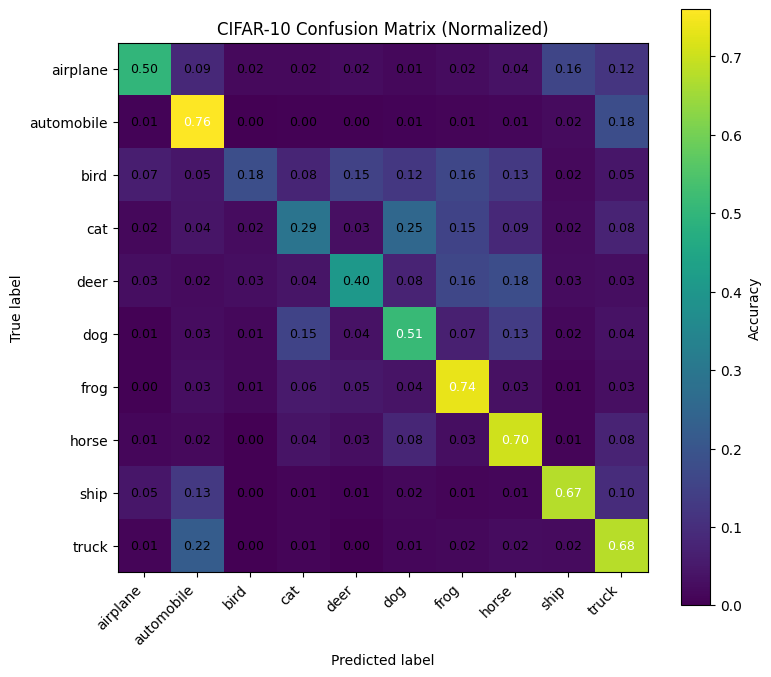

In [105]:
plt.figure(figsize=(8, 7))
plt.imshow(cm_norm, interpolation="nearest")
plt.colorbar(label="Accuracy")

plt.xticks(np.arange(10), class_names, rotation=45, ha="right")
plt.yticks(np.arange(10), class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Normalized)")

# Annotate cells
for i in range(10):
    for j in range(10):
        plt.text(
            j, i,
            f"{cm_norm[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black",
            fontsize=9
        )

plt.tight_layout()
plt.show()